In [75]:
import common.star_api.design_manager as dm
import common.visualization as viz
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from SALib.analyze import sobol
import seaborn as sns

version = dm.STARCCMInstall(r"E:\Siemens\STARCCM\starpy\STAR-CCM+19.04.007-2-ga404231\star\bin\starccm+.bat")
work_dir = Path(r"E:\OneDrive - Siemens AG\mdx\hackathon\2024\starPy\svd")
name = "svd_proj_test"


In [ ]:
dmprj = dm.DesignManagerProject.get_proj(work_dir=work_dir, dmprj=name, version=version)

In [53]:
print(f"Study {study.name} runtime = {study.runtime()}")

Study Sherpa_P runtime = 2 days, 5:16:49


In [76]:
def plot_statistical_histories(proj):
    only_opt = [s for s in proj if "Sherpa_" in s.name]
    max_designs = -1
    for s in only_opt:
        current_number = len(s.get_all_designs().data)
        if current_number > max_designs:
            max_designs = current_number
    d = {"Design#": np.arange(1, max_designs + 1)}
    for study in only_opt:
        data = study.get_design_set("All Best").generate_history(col_name="L_over_D", max_designs=max_designs)
        d[study.name] = data[:, 1]

    data = pd.DataFrame(d)
    data2 = data[data.columns[1:]]
    data["Min"] = data2.min(axis=1)
    data["Average"] = data2.mean(axis=1)
    data["Median"] = data2.median(axis=1)
    data["Max"] = data2.max(axis=1)
    data["Q1"] = data2.quantile(0.25, axis=1)
    data["Q3"] = data2.quantile(0.75, axis=1)
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    ax = axes[1]
    x = data["Design#"].to_numpy()
    med = data["Median"].to_numpy()
    q1 = data["Q1"].to_numpy()
    q3 = data["Q3"].to_numpy()
    ax.plot(x, med, color="k", linestyle="-", linewidth=1.5, label="Median")
    ax.fill_between(x, q1, q3, alpha=0.25, color="k", label="IQR")
    ax.set_title("L/D Performance - Statistical")
    ax.set_ylabel("L/D")
    ax.set_xlabel("Design Number")
    ax.set_ylim([75, 225])
    ax.set_yticks([v for v in range(75, 250, 25)])
    ax.legend(loc="upper left")

    ax = axes[0]
    ax.set_xlabel("Design Number")
    ax.set_ylabel("L/D")
    ax.set_ylim([75, 225])
    ax.set_yticks([v for v in range(75, 250, 25)])
    ax.set_title("L/D Performance - Individual")
    for study in only_opt:
        label = study.name.split("_")[-1]
        data = study.get_all_designs().data_frame()
        ax = viz.plot_history(df=data, y_col="L_over_D", best_design=False, scatter=False, ax=ax, label=label)
    ax.legend(loc="upper left")
    plt.tight_layout()
    fig.savefig(work_dir.joinpath("svd_statistical.png"), dpi=300)

In [90]:
def get_param_names(study: dm.Study):
    continuous = [p for p in study.parameters if p.type == dm.Parameter.Type.CONTINUOUS]
    param_names = [p.name for p in continuous]
    successful = study.get_design_set("Successful").data_frame()

    param_names_adjusted = []
    for p in param_names:
        for c in successful.columns:
            regex = f"^{p}( \(.*\))?$"
            if re.match(regex, c):
                param_names_adjusted.append(c)
                found = True
                break
        if not found:
            print(f"Parameter name '{p}' not found in successful design columns. Using original name.")
            param_names_adjusted.append(p)
    return param_names_adjusted


def get_param_values(study: dm.Study):
    successful = study.get_design_set("Successful").data_frame()
    param_values = successful[get_param_names(study)]
    return param_values;

def get_responses(study: dm.Study, response_column: str):
    successful = study.get_design_set("Successful").data_frame()
    responses = successful[response_column].values
    return responses

def calc_boruta(study: dm.Study):
    params = get_param_values(study)
    response = study.get_design_set("Successful").data_frame()["Cd"]

    ### initialize hits counter
    hits = np.zeros((len(params.columns)))

    rows_list = []
    param_names = get_param_names(study)

    ### repeat 50 times
    for iter_ in range(50):
        
        ### make params_shadow by randomly permuting each column of parameter values
        np.random.seed(iter_)
        params_shadow = params.apply(np.random.permutation)
        params_boruta = pd.concat([params, params_shadow], axis = 1)

        ### fit a random forest (suggested max_depth between 3 and 7)
        forest = RandomForestRegressor(max_depth = 5, random_state = 42)
        forest.fit(params_boruta, response)

        ### store feature importance
        feat_imp_params = forest.feature_importances_[:len(params.columns)]
        feat_imp_shadow = forest.feature_importances_[len(params.columns):]
        imp_series = pd.Series(feat_imp_params, index=param_names)
        dict1 = {}
        dict1.update(imp_series)
        rows_list.append(dict1)

        ### MIRA (cutoff to mark a feature as accepted)
        cutoff = feat_imp_shadow.max()
        #print(cutoff)

        ### compute hits for this trial and add to counter
        hits += (feat_imp_params > cutoff)

    zscore_hist = pd.DataFrame(rows_list)
    sort_order = zscore_hist.mean().sort_values()
    zscore_sorted = zscore_hist.reindex(sort_order.index, axis=1)
    
    hits_series = pd.Series(hits, index=param_names, dtype=int)
    dict2 = {}
    dict2.update(hits_series)
    hits_list = []
    hits_list.append(dict2)
    hits_df = pd.DataFrame(hits_list)
    hits_sorted = hits_df.reindex(sort_order.index, axis=1)
    hits_filtered = hits_sorted.loc[:, hits_sorted.loc[0] > 19]
    zscore_filtered = zscore_sorted.loc[:, hits_sorted.loc[0] > 19]
    
    colors = []
    for h in hits_filtered:
        if hits_filtered[h].iloc[0] < 20:
            colors.append("black")
        elif hits_filtered[h].iloc[0] < 31:
            colors.append("yellow")
        else:
            colors.append("green")
    return zscore_filtered,colors

def plot_scatter_plots(param_values, param_names, responses, axes):
    x_label_prefixes = ["A", "B", "C", "D", "E", "F", "G", "H"]
    for i, param_name in enumerate(param_names):
        ax = axes[i]
        ax.scatter(param_values[:, i], responses, alpha=0.5)
        ax.set_xlabel(f"{x_label_prefixes[i]} = {param_name}")

def plot_sobol_indices(Si, param_values, param_names, responses):
    param_labels = ["A", "B", "C", "D", "E", "F", "G", "H"]

    fig = plt.figure(layout="constrained", figsize=(15, 7))
    gs0 = gridspec.GridSpec(2, 2, figure=fig)
    gs00 = gs0[1, 0].subgridspec(4, 2, wspace=0)
    axes = gs00.subplots(sharey="row").flatten()
    ax1 = fig.add_subplot(gs0[0, 0])
    ax0 = fig.add_subplot(gs0[0, 1])
    ax3 = fig.add_subplot(gs0[1, 1])

    # First-order indices
    ax0.bar(param_names, Si['S1'])
    ax0.set_title('First-Order Sobol Indices')
    ax0.set_xlabel("Parameter")
    ax0.set_xticks([i for i in range(8)], param_labels)

    # Total indices
    ax1.bar(param_names, Si['ST'])
    ax1.set_title('Total Sobol Indices')
    ax1.set_xlabel("Parameter")
    ax1.set_xticks([i for i in range(8)], param_labels)

    sns.heatmap(Si['S2'], xticklabels=param_labels, yticklabels=param_labels, annot=True, fmt=".2f", cmap='viridis',
                ax=ax3)
    ax3.set_title('Second-order Sobol indices')
    ax3.set_xlabel("Parameter")
    ax3.set_ylabel("Parameter")

    plot_scatter_plots(param_values, param_names, responses, axes)
    plt.show()

In [78]:
def get_param_values(study: dm.Study):
    successful = study.get_design_set("Successful").data_frame()
    param_values = successful[get_param_names(study)]
    return param_values;

In [79]:
def calc_boruta(study: dm.Study):
    params = get_param_values(study)
    response = study.get_design_set("Successful").data_frame()["Cd"]

    ### initialize hits counter
    hits = np.zeros((len(params.columns)))

    rows_list = []
    param_names = get_param_names(study)

    ### repeat 50 times
    for iter_ in range(50):
        
        ### make params_shadow by randomly permuting each column of parameter values
        np.random.seed(iter_)
        params_shadow = params.apply(np.random.permutation)
        params_boruta = pd.concat([params, params_shadow], axis = 1)

        ### fit a random forest (suggested max_depth between 3 and 7)
        forest = RandomForestRegressor(max_depth = 5, random_state = 42)
        forest.fit(params_boruta, response)

        ### store feature importance
        feat_imp_params = forest.feature_importances_[:len(params.columns)]
        feat_imp_shadow = forest.feature_importances_[len(params.columns):]
        imp_series = pd.Series(feat_imp_params, index=param_names)
        dict1 = {}
        dict1.update(imp_series)
        rows_list.append(dict1)

        ### MIRA (cutoff to mark a feature as accepted)
        cutoff = feat_imp_shadow.max()
        #print(cutoff)

        ### compute hits for this trial and add to counter
        hits += (feat_imp_params > cutoff)

    zscore_hist = pd.DataFrame(rows_list)
    sort_order = zscore_hist.mean().sort_values()
    zscore_sorted = zscore_hist.reindex(sort_order.index, axis=1)
    
    hits_series = pd.Series(hits, index=param_names, dtype=int)
    dict2 = {}
    dict2.update(hits_series)
    hits_list = []
    hits_list.append(dict2)
    hits_df = pd.DataFrame(hits_list)
    hits_sorted = hits_df.reindex(sort_order.index, axis=1)
    hits_filtered = hits_sorted.loc[:, hits_sorted.loc[0] > 19]
    zscore_filtered = zscore_sorted.loc[:, hits_sorted.loc[0] > 19]
    
    colors = []
    for h in hits_filtered:
        if hits_filtered[h].iloc[0] < 20:
            colors.append("black")
        elif hits_filtered[h].iloc[0] < 31:
            colors.append("yellow")
        else:
            colors.append("green")
    return zscore_filtered,colors

In [80]:
def plot_box(zscore_hist, colors, ax):
    ax.set_yscale("log")
    ax.set_xticks(np.arange(1, len(zscore_hist.keys()) + 1), labels=zscore_hist.keys(), rotation=45)
    ax.set_title("Boruta Box and Whiskers Plot Cd")
    ax.set_ylabel("Cd Z Score")
    ax.set_xlabel("Parameters")
    box = ax.boxplot(np.array(zscore_hist), tick_labels=zscore_hist.keys(), patch_artist=True)
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

In [81]:
def plot_violin(zscore_hist, colors, ax):
    ax.set_title('Boruta Violin Plot Cd')
    ax.set_ylabel('Cd Z Score')
    ax.set_yscale("log")
    ax.set_xlabel('Parameters')
    ax.set_xticks(np.arange(1, len(zscore_hist.keys()) + 1), labels=zscore_hist.keys(), rotation=45)

    violin = ax.violinplot(np.array(zscore_hist), showmedians=True)
    j = 0
    for i, pc in enumerate(violin["bodies"], 1):
        pc.set_facecolor(colors[j])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        j += 1
    for partname in ('cbars', 'cmins', 'cmaxes'):
        vp = violin[partname]
        vp.set_edgecolor("black")
        vp.set_linewidth(1)


In [82]:
def boruta_sensitivity():
    dmprj = dm.DesignManagerProject.get_proj(work_dir=work_dir, dmprj=name, version=version)
    study = dmprj.studies[0]
    zscore_hist,colors = calc_boruta(study)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 5))
    plot_box(zscore_hist, colors, ax1)
    plot_violin(zscore_hist,colors, ax2)
    plt.tight_layout()
    plt.show()

In [87]:
def run_sobol_analysis(study: dm.Study, response_column: str):
    param_names = get_param_names(study)
    param_values = get_param_values(study).values
    responses = get_responses(study, response_column)

    D = len(param_names)  # Number of parameters
    N = len(responses)  # Number of samples
    calc_second_order = True  # Using first-order Sobol analysis

    if calc_second_order and N % (2 * D + 2) != 0:
        raise RuntimeError("Incorrect number of samples in model output file for second-order Sobol analysis.")
    elif not calc_second_order and N % (D + 2) != 0:
        raise RuntimeError("Incorrect number of samples in model output file for first-order Sobol analysis.")

    problem = {
        'num_vars': D,
        'names': param_names,
        'bounds': [[min(param_values[:, i]), max(param_values[:, i])] for i in range(D)]
    }

    assert not np.any(np.isnan(param_values)), "NaN values found in param_values"
    assert not np.any(np.isinf(param_values)), "Infinite values found in param_values"
    assert not np.any(np.isnan(responses)), "NaN values found in responses"
    assert not np.any(np.isinf(responses)), "Infinite values found in responses"

    Si = sobol.analyze(problem, responses, calc_second_order=calc_second_order)

    plot_sobol_indices(Si, param_values, param_names, responses)

In [88]:
def sobol_sensitivity():
    work_dir = Path(r"E:\OneDrive - Siemens AG\mdx\hackathon\2024\starPy\exhaust")
    name = "exhaust_test"
    version = dm.STARCCMInstall(r"E:\Siemens\STARCCM\starpy\STAR-CCM+19.04.007-2-ga404231\star\bin\starccm+.bat")
    study_name = "Single Opt - Min 1 Const"
    response_column = "Pressure Drop MA (Pa)"

    project = dm.DesignManagerProject.get_proj(work_dir=work_dir, dmprj=name, version=version)
    study = project.get_study(study_name)
    run_sobol_analysis(study, response_column)

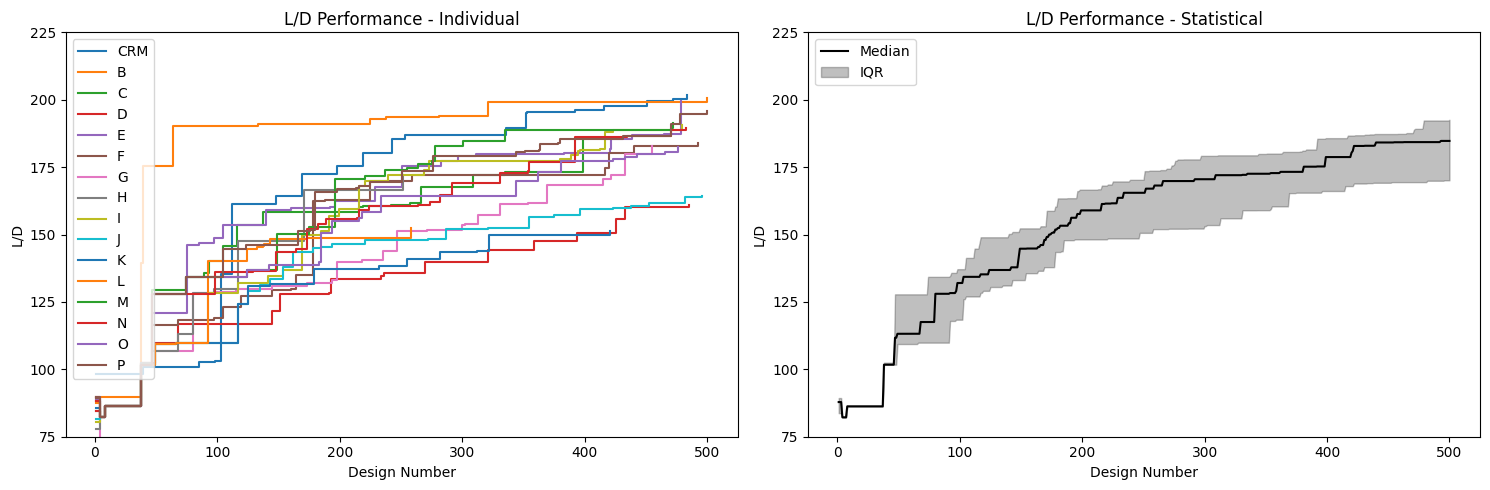

In [85]:
plot_statistical_histories(dmprj)

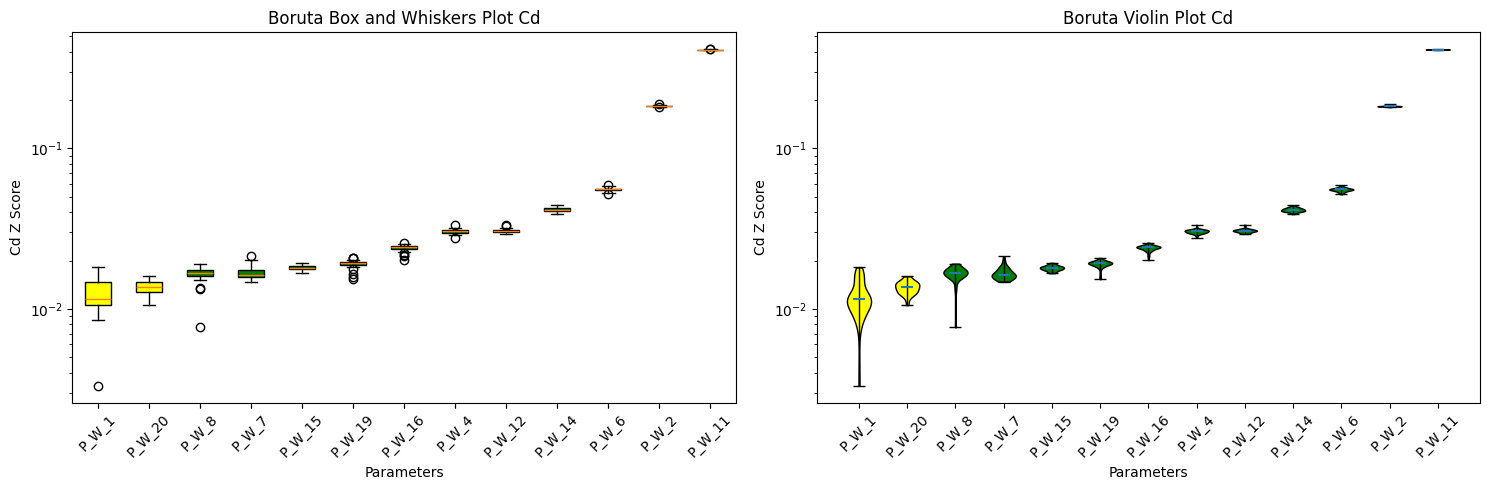

In [73]:
boruta_sensitivity()

D:\PycharmProjects\hackStarPy\venv\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


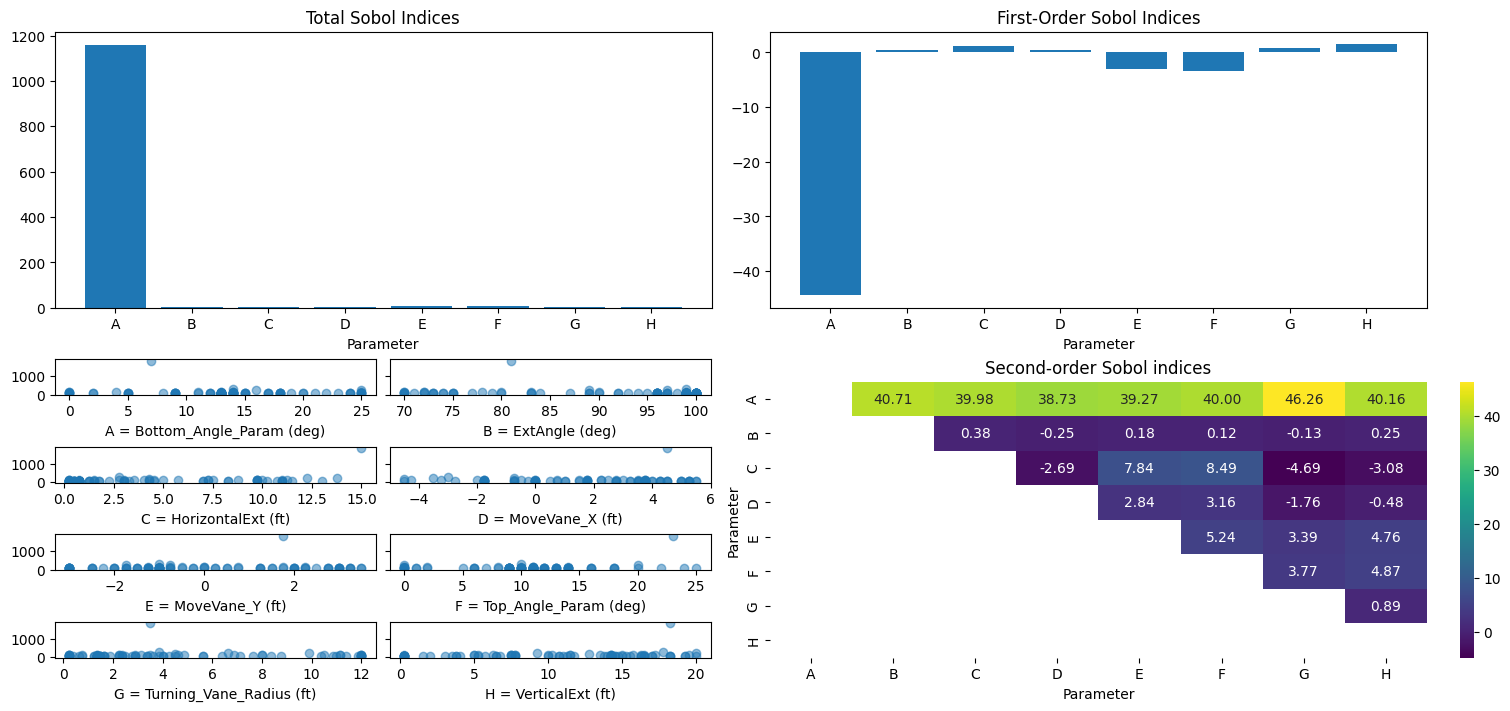

In [91]:
sobol_sensitivity()